In [1]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm

# Plotting and Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Language Detection packages
# `langdetect` for detecting language
from langdetect import detect as langdetect_detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
# `langid` for an alternative language detection method
from langid import classify as langid_classify

# Text Preprocessing and NLP
# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords
# Tokenizing sentences/words
from nltk.tokenize import word_tokenize
# Part-of-speech tagging
from nltk import pos_tag
# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer
import nltk
# Regular expressions for text pattern matching
import re

# Word Cloud generation
from wordcloud import WordCloud

In [2]:
import os
import sys
from pathlib import Path

if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("working dir:", workding_dir)

working dir: /Users/inflaton/code/engd/papers/DM-Fake-News-Detection


In [3]:
from datasets import load_dataset, concatenate_datasets, Dataset

datasets = load_dataset(
    "csv",
    data_files={
        "train": [
            "dataset/train_data_1.csv",
            "dataset/train_data_2.csv",
            "dataset/train_data_3.csv",
            "dataset/train_data_4.csv",
        ],
        "test": "dataset/test_data.csv",
        "rewritten_train": [
            "dataset/rewritten_train_data_1.csv",
            "dataset/rewritten_train_data_2.csv",
            "dataset/rewritten_train_data_3.csv",
            "dataset/rewritten_train_data_4.csv",
        ],
        "rewritten_test": "dataset/rewritten_test_data.csv",
    },
)
datasets

/Users/inflaton/anaconda3/envs/fake-news/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
    rewritten_train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    rewritten_test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
})

### RNN with Word2Vec (best RNN model)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
import tensorflow as tf
import numpy as np
import random

from gensim.models import Word2Vec
import numpy as np

def train_word2vec_embeddings(train_texts, word_index, vocab_size=5000, embedding_dim=128):
    """Tokenizes text, trains Word2Vec, and creates an embedding matrix."""
    sentences = [text.split() for text in train_texts]  # Convert text into word lists

    # Train Word2Vec
    word2vec_model = Word2Vec(sentences=sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4, sg=1)

    # Initialize embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if i < vocab_size and word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

    return embedding_matrix


def create_rnn_model(vocab_size, embedding_matrix, input_length, rnn_units=64, dropout_rate=0.5, learning_rate=0.001):
    """Creates an RNN model using Word2Vec embeddings."""
    model = Sequential([
        Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], 
                  input_length=input_length, trainable=True),
        SimpleRNN(rnn_units, activation='tanh'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [6]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def evaluate_model(model, train_data, val_data):
    print("Evaluating Model")

    max_words = 10000
    max_sequence_length = 300

    train_texts = train_data["processed_full_content"]
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train_texts)

    y_val = val_data["label"]
    val_texts = val_data["processed_full_content"]

    X_val = pad_sequences(
        tokenizer.texts_to_sequences(val_texts), maxlen=max_sequence_length
    )
    y_pred = (model.predict(X_val) > 0.5).astype(int)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}

In [7]:
train_data = datasets["train"].to_pandas()
val_data = datasets["test"].to_pandas()
data = pd.concat([train_data, val_data], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60491 entries, 0 to 60490
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   label                   60491 non-null  int64 
 1   full_content            60491 non-null  object
 2   processed_full_content  60491 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [8]:
# load model
from tensorflow.keras.models import load_model

model = load_model("results/RNN_model_original.keras")
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 300, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_20 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,957,253 (7.47 MB)

 Trainable params: 652,417 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,304,836 (4.98 MB)

In [9]:
%%time
perf_original_model_val_data = evaluate_model(model, train_data, val_data)


Evaluating Model
 41/190 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

I0000 00:00:1740103627.644213 5332893 service.cc:148] XLA service 0x3ca436030 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740103627.644229 5332893 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-02-21 10:07:07.653896: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740103627.683552 5332893 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.9428
Precision: 0.9492
Recall: 0.9184
F1: 0.9336
CPU times: user 7.87 s, sys: 89.5 ms, total: 7.96 s
Wall time: 7.88 s


In [10]:
val_data_rewritten = datasets["rewritten_test"].to_pandas()
train_data_rewritten = datasets["rewritten_train"].to_pandas()

In [11]:
%%time

perf_original_model_val_data_rewritten = evaluate_model(model, train_data, val_data_rewritten)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7476
Precision: 0.8222
Recall: 0.5399
F1: 0.6518
CPU times: user 7.62 s, sys: 71.6 ms, total: 7.69 s
Wall time: 7.64 s


In [12]:
train_data_combined = pd.concat([train_data, train_data_rewritten], ignore_index=True)
val_data_combined = pd.concat([val_data, val_data_rewritten], ignore_index=True)

In [13]:
model_combined = load_model("results/RNN_model_combined.keras")
model_combined.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_41 (Embedding)        │ (None, 300, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_41 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,935,557 (7.38 MB)

 Trainable params: 645,185 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,290,372 (4.92 MB)

In [14]:
perf_combined_model_val_data = evaluate_model(model_combined, train_data_combined, val_data)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9367
Precision: 0.9081
Recall: 0.9516
F1: 0.9293


In [15]:
perf_combined_model_val_data_rewritten = evaluate_model(model_combined, train_data_combined, val_data_rewritten)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8233
Precision: 0.7508
Recall: 0.8923
F1: 0.8155


In [16]:
model_rewritten = load_model("results/RNN_model_rewritten.keras")
model_rewritten.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,935,557 (7.38 MB)

 Trainable params: 645,185 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,290,372 (4.92 MB)

In [17]:
perf_rewritten_model_val_data = evaluate_model(model_rewritten, train_data_rewritten, val_data)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9003
Precision: 0.9178
Recall: 0.8481
F1: 0.8816


In [18]:
perf_rewritten_model_val_data_rewritten = evaluate_model(model_rewritten, train_data_rewritten, val_data_rewritten)

Evaluating Model
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8231
Precision: 0.8466
Recall: 0.7276
F1: 0.7826


Results saved to results/RNN_metrics.csv


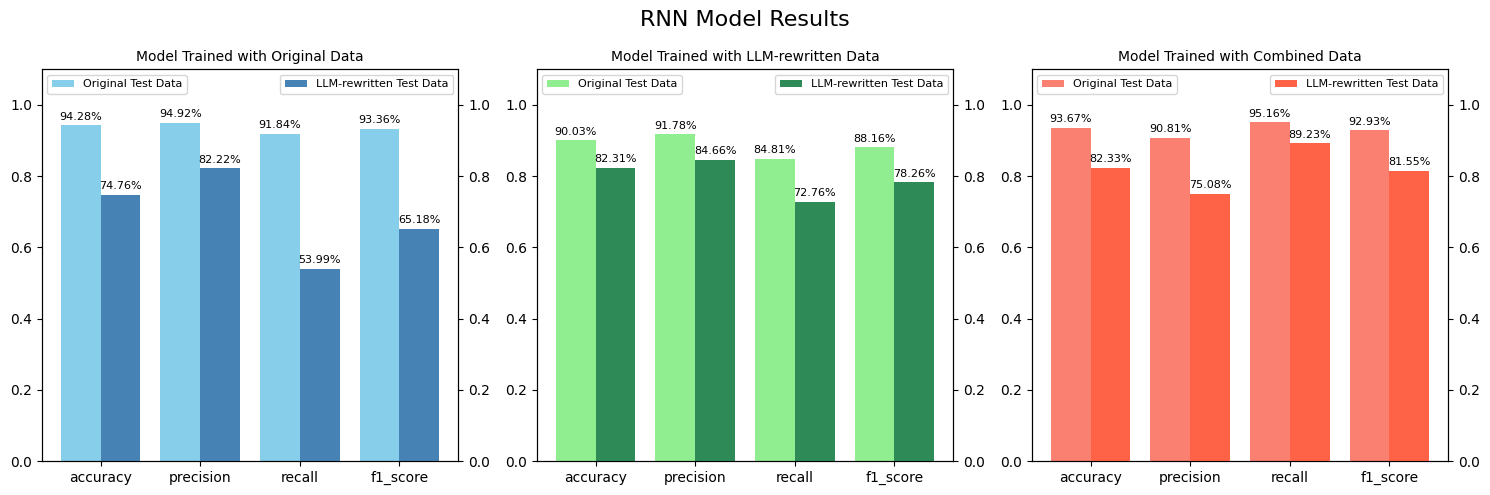

In [19]:
from llm_experiements.utils import *

model = "RNN"
save_results(model, perf_original_model_val_data, perf_original_model_val_data_rewritten, 
             perf_combined_model_val_data, perf_combined_model_val_data_rewritten, 
             perf_rewritten_model_val_data, perf_rewritten_model_val_data_rewritten)

plot_results(model, perf_original_model_val_data, perf_original_model_val_data_rewritten, 
             perf_combined_model_val_data, perf_combined_model_val_data_rewritten, 
             perf_rewritten_model_val_data, perf_rewritten_model_val_data_rewritten)